# Urban and rural surrounding areas selection

***
> This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0)
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Load libraries

Here we load the required libraries to execute the notebook. Note that specific code from dedicated scripts (`utils.py`, `urban_areas.py`, ...) is also loaded here.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import numpy as np
import xarray as xr
import cf_xarray as cfxr
from pathlib import Path
import cftime
import pandas as pd
import matplotlib
from pprint import pprint

from urbanmask.urban_areas import (
    UrbanVicinity
)
from urbanmask.UHI_plot_functions import (
    plot_climatology,
    plot_annual_cycle
)
from urbanmask.utils import (
    kelvin2degC,
    traverseDir,
    fix_360_longitudes,
    RCM_DICT
)
from urbanmask.UHI_analysis import UrbanIsland

## Input parameters

These parameters define the behaviour of the notebook, by selecting the `city`, `variable`, and some other items which are mostly self-explanatory. _(Explain here those with are not)_

In [3]:
city = 'PortoAlegre'
lon_city = -51.2090
lat_city = -30.0368

domain = 'CSAM-4'
model = 'WRF433'
scenario = "evaluation"

urban_th = 60
urban_sur_th = 1
orog_diff = 100
sftlf_th = 70
scale = 2
min_city_size = 6
lon_lim = 1
lat_lim = 1
urban_var = 'sfturf'

Create a directory to save the results for this particular city and model

In [4]:
base_output_dir = 'results'
output_dir = f"{base_output_dir}/{city}-{domain}_{model}"
os.makedirs(output_dir, exist_ok = True)

Infer doman resolution in degrees and create filename

In [5]:
domain_resolution = int(domain.split('-')[1])
base_filename = f'{city}-{domain}_ECMWF-ERA5_{scenario}_r1i1p1f1_{model}'

## Define urban areas and vicinity

### Load static variables
Load static variables, such as urban fraction (sfturf), terrain elevation (orography) or land-sea fraction (sftlf).

In [6]:
root = "/lustre/gmeteo/WORK/ASNA/projects/fpssam/03_FPS-SESA-ext-CPM/data/CORDEX-FPS-SESA/output/CSAM-4/UCAN/ECMWF-ERA5/evaluation/r1i1p1f1/UCAN-WRF433/v1/"

In [7]:
ds_sfturf = xr.open_dataset(f'{root}fx/landuse/landuse_CSAM-4_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_fx.nc')
ds_orog = xr.open_dataset(f'{root}fx/orog/orog_CSAM-4_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_fx.nc')
ds_sftlf = xr.open_dataset(f'{root}fx/sftlf/sftlf_CSAM-4_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_fx.nc')

ds_sfturf[urban_var] = (ds_sfturf['landuse'] == 13)*100

Add parameters to the function

In [8]:
URBAN = UrbanVicinity(
    urban_sur_th = urban_sur_th,
    orog_diff = orog_diff,
    sftlf_th = sftlf_th,
    scale = scale,
    min_city_size = min_city_size,
    lon_city = lon_city,
    lat_city = lat_city,
    lon_lim = lon_lim,
    lat_lim = lat_lim,
    model = model,
    domain = domain,
    urban_th = urban_th,
    urban_var = urban_var
)

Crop area around de city

In [9]:
ds_sfturf = URBAN.crop_area_city(ds = ds_sfturf, res = domain_resolution)
ds_orog = URBAN.crop_area_city(ds = ds_orog, res = domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds = ds_sftlf, res = domain_resolution)

Define masks using the parameters above

In [10]:
sfturf_mask, sfturf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sfturf = ds_sfturf, 
    ds_orog = ds_orog, 
    ds_sftlf = ds_sftlf,
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [11]:
urmask = URBAN.select_urban_vicinity(
    sfturf_mask = sfturf_mask, 
    orog_mask = orog_mask,
    sftlf_mask = sftlf_mask,
    sfturf_sur_mask = sfturf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

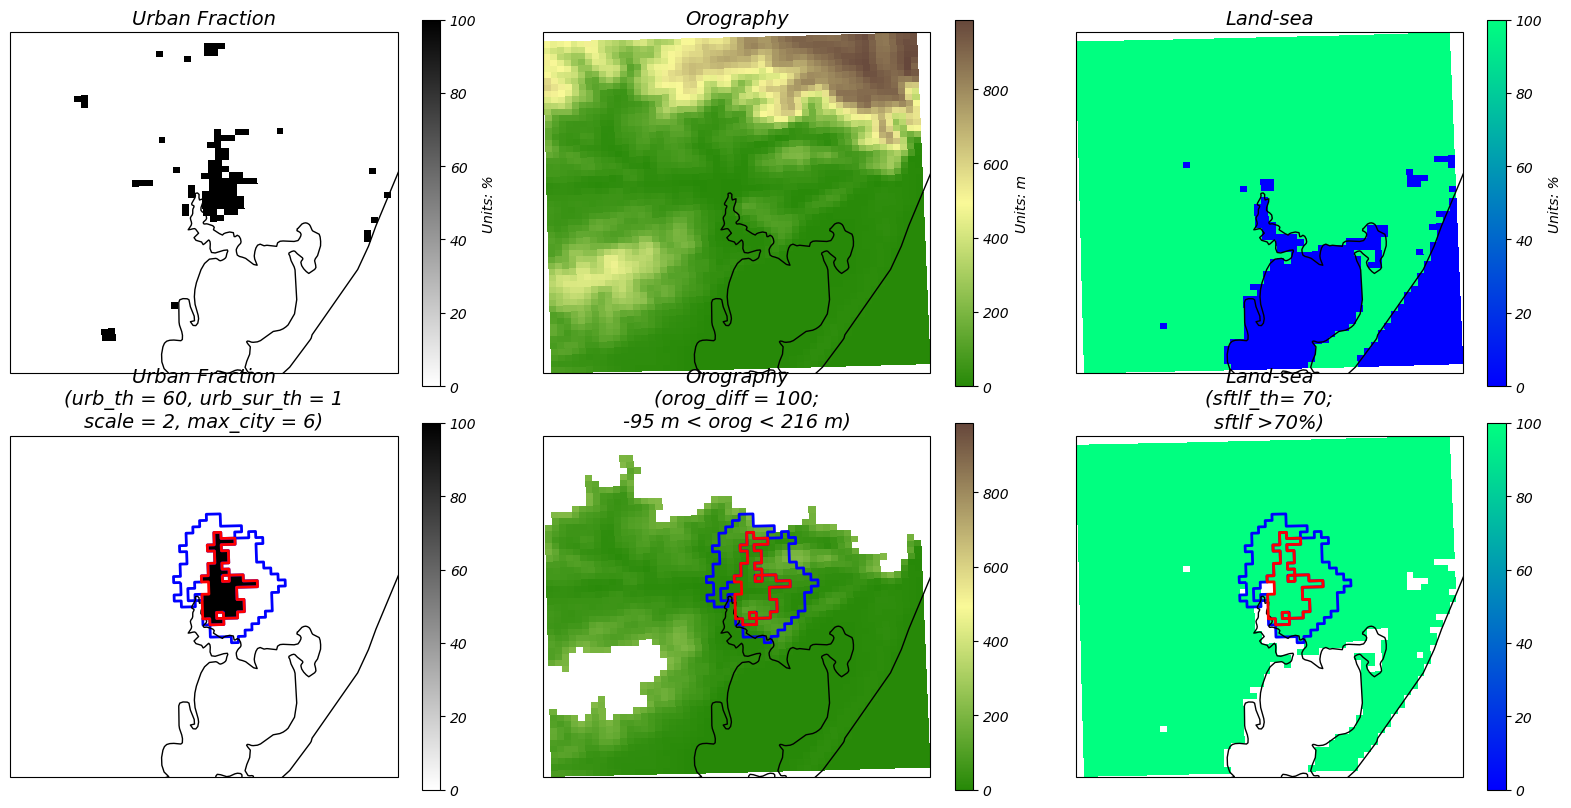

In [12]:
fig = URBAN.plot_static_variables(ds_sfturf = ds_sfturf, 
                                  ds_orog = ds_orog, 
                                  ds_sftlf = ds_sftlf,
                                  sfturf_mask = sfturf_mask, 
                                  orog_mask = orog_mask, 
                                  sftlf_mask = sftlf_mask,
                                  urban_areas = urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')

Save these masks and urban fraction to NetCDF

In [13]:
urmask.to_netcdf(f"{output_dir}/urmask_{base_filename}_fx.nc")

In [14]:
pprint(dict(urmask['urmask'].attrs))

{'domain': 'CSAM-4',
 'lat_city': -30.0368,
 'lat_lim': 1,
 'lon_city': -51.209,
 'lon_lim': 1,
 'long_name': 'Urban vs. vicinity. 1 corresponds to urban areas and 0 to the '
              'surrounding areas',
 'min_city_size': 6,
 'model': 'WRF433',
 'orog_diff': 100,
 'scale': 2,
 'sftlf_th': 70,
 'urban_sur_th': 1,
 'urban_th': 60}


## Calculate Urban Heat Island (UHI)

### Load climate variable

In [15]:
variable = 'tasmin'

In [16]:
files = np.sort(list(traverseDir(root + 'day/tasmin/')))
ds_RCM = xr.open_mfdataset(files, concat_dim = 'time', combine='nested')
ds_RCM = kelvin2degC(ds_RCM, variable)
ds_RCM = fix_360_longitudes(ds_RCM)
ds_RCM = URBAN.crop_area_city(ds = ds_RCM, res = domain_resolution).compute()

### Compute the climatology of anomalies with respect to rural vicinity mean

In [17]:
UHI = UrbanIsland(
    ds = ds_RCM[variable],
    urban_vicinity = urmask,
    anomaly = 'abs'
)

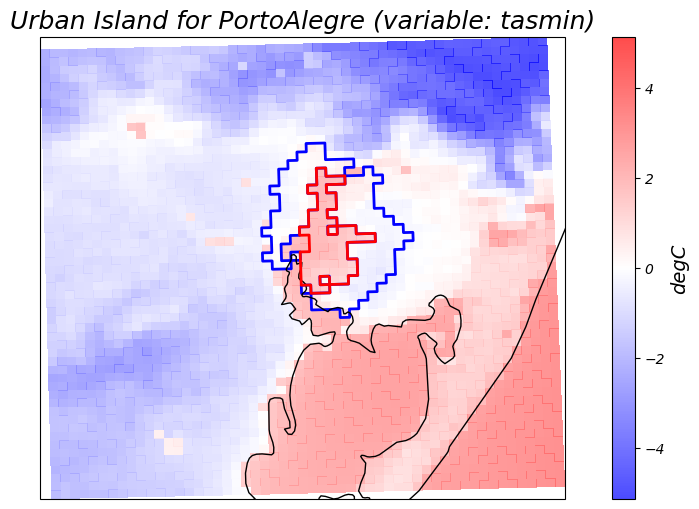

In [18]:
fig = UHI.plot_UI_map(
    city_name = city,
)
fig.savefig(f"{output_dir}/{variable}_{base_filename}_map-anom-wrt-rural.pdf", bbox_inches='tight')

### Compute the annual cycle climatology of anomalies with respect to rural vicinity mean

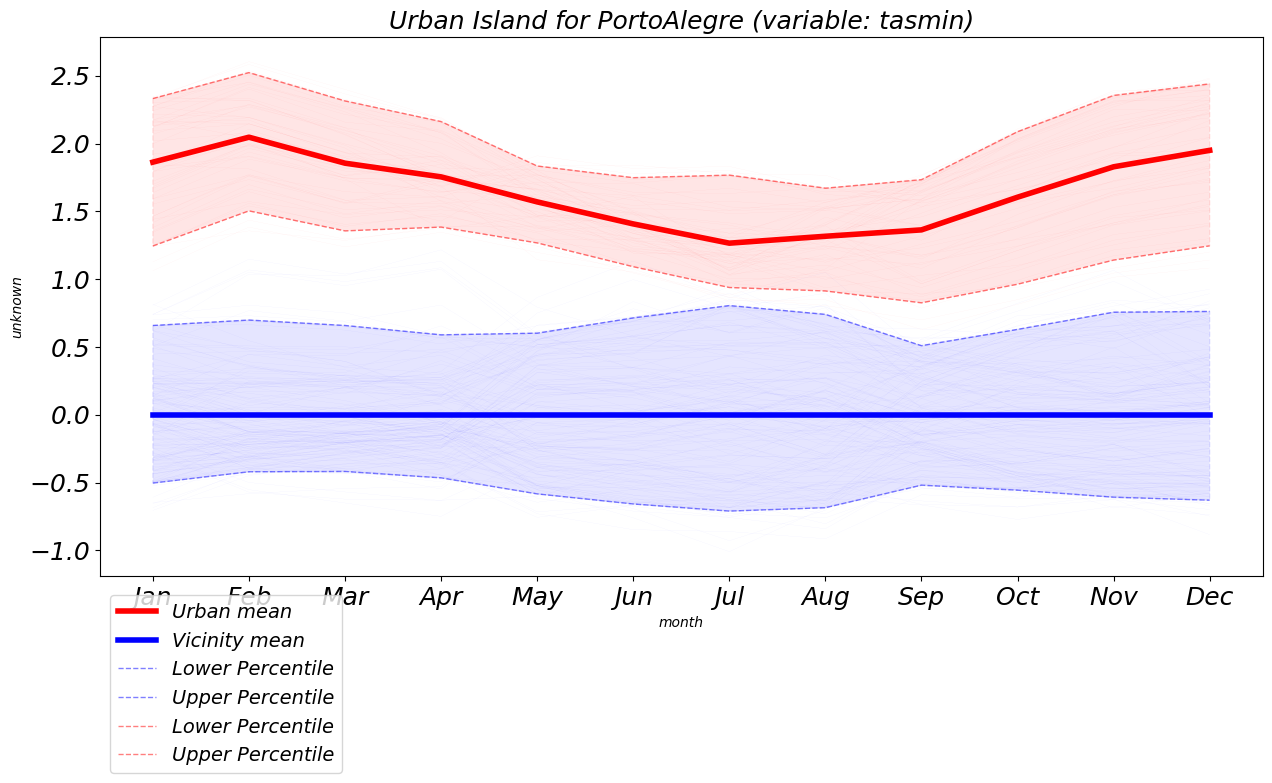

In [27]:
fig = UHI.plot_UI_annual_cycle(
    percentiles = [5],
    gridcell_series = True, 
    city_name = city)

## Buenos Aires REMO

In [29]:
city = 'BuenosAries'
lon_city = -58.416
lat_city = -34.559

domain = 'SAM-22'
model = 'REMO'
scenario = "evaluation"

urban_var = 'sftimf'

urban_th = 10
urban_sur_th = 10
orog_diff = 50
sftlf_th = 70
scale = 2
min_city_size = 0
lon_lim = 1
lat_lim = 1

Create a directory to save the results for this particular city and model

In [30]:
base_output_dir = 'results'
output_dir = f"{base_output_dir}/{city}-{domain}_{model}"
os.makedirs(output_dir, exist_ok = True)

Infer doman resolution in degrees and create filename

In [31]:
domain_resolution = int(domain.split('-')[1])
base_filename = f'{city}-{domain}_ECMWF-ERA5_{scenario}_r1i1p1f1_{model}'

## Define urban areas and vicinity

### Load static variables
Load static variables, such as urban fraction (sfturf), terrain elevation (orography) or land-sea fraction (sftlf).

In [32]:
root_nextcloud = '/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'
root_esgf = "/lustre/gmeteo/DATA/ESGF/REPLICA/DATA/cordex/output/"

In [33]:
file_sfturf = glob.glob(
        f"{root_nextcloud}{model}/{urban_var}/{urban_var}_{domain}*.nc" 
)

file_orog = glob.glob(
    f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/ECMWF-ERAINT/evaluation/*/{RCM_DICT[domain][model].split('_')[1]}/*/fx/orog/*/orog_*.nc" 
)
file_sftlf = glob.glob(
    f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/ECMWF-ERAINT/evaluation/*/{RCM_DICT[domain][model].split('_')[1]}/*/fx/sftlf/*/sftlf_*.nc" 
)

In [34]:
ds_sfturf = xr.open_dataset(file_sfturf[0])
ds_orog = xr.open_dataset(file_orog[0])
ds_sftlf = xr.open_dataset(file_sftlf[0])

ds_sfturf = fix_360_longitudes(ds_sfturf)
ds_orog = fix_360_longitudes(ds_orog)
ds_sftlf = fix_360_longitudes(ds_sftlf)

Add parameters to the function

In [35]:
URBAN = UrbanVicinity(
    urban_sur_th = urban_sur_th,
    orog_diff = orog_diff,
    sftlf_th = sftlf_th,
    scale = scale,
    min_city_size = min_city_size,
    lon_city = lon_city,
    lat_city = lat_city,
    lon_lim = lon_lim,
    lat_lim = lat_lim,
    model = model,
    domain = domain,
    urban_th = urban_th,
    urban_var = urban_var
)

Crop area around de city

In [36]:
ds_sfturf = URBAN.crop_area_city(ds = ds_sfturf, res = domain_resolution)
ds_orog = URBAN.crop_area_city(ds = ds_orog, res = domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds = ds_sftlf, res = domain_resolution)

Define masks using the parameters above

In [37]:
sfturf_mask, sfturf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sfturf = ds_sfturf, 
    ds_orog = ds_orog, 
    ds_sftlf = ds_sftlf,
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [38]:
urmask = URBAN.select_urban_vicinity(
    sfturf_mask = sfturf_mask, 
    orog_mask = orog_mask,
    sftlf_mask = sftlf_mask,
    sfturf_sur_mask = sfturf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

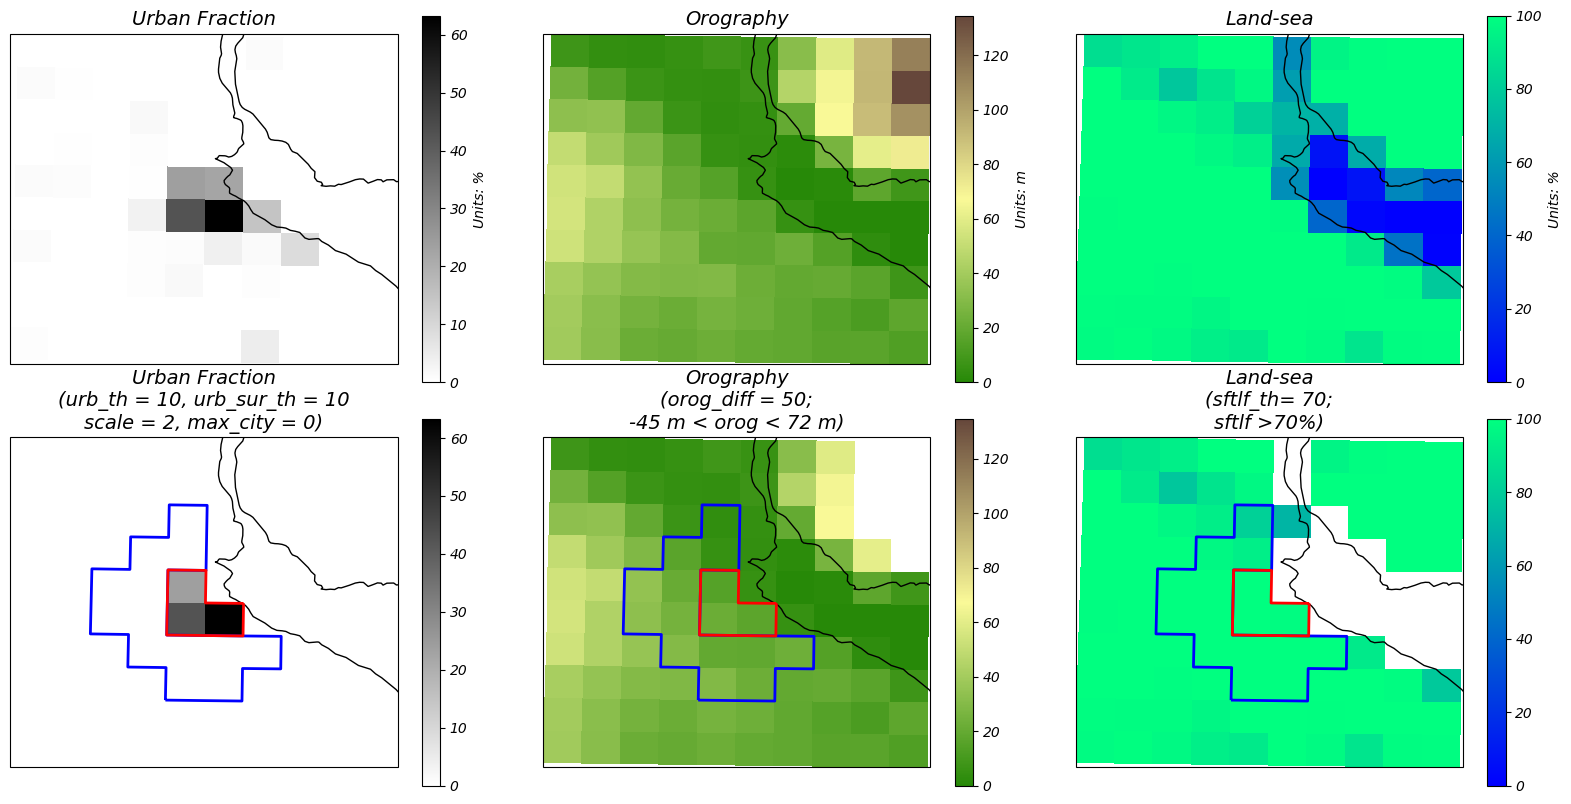

In [39]:
fig = URBAN.plot_static_variables(ds_sfturf = ds_sfturf, 
                                  ds_orog = ds_orog, 
                                  ds_sftlf = ds_sftlf,
                                  sfturf_mask = sfturf_mask, 
                                  orog_mask = orog_mask, 
                                  sftlf_mask = sftlf_mask,
                                  urban_areas = urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')

Save these masks and urban fraction to NetCDF

In [40]:
urmask.to_netcdf(f"{output_dir}/urmask_{base_filename}_fx.nc")

## Calculate urban heat island effect

### Load climate variable

In [46]:
variable = 'tasmin'

In [47]:
files = np.sort(list(traverseDir(root + 'day/tasmin/')))
ds_RCM = xr.open_mfdataset(files, concat_dim = 'time', combine='nested')
ds_RCM = kelvin2degC(ds_RCM, variable)
ds_RCM = fix_360_longitudes(ds_RCM)
ds_RCM = URBAN.crop_area_city(ds = ds_RCM, res = domain_resolution).compute()

### Compute the climatology of anomalies with respect to rural vicinity mean

In [57]:
UHI = UrbanIsland(
    ds = ds_RCM[variable],
    urban_vicinity = urmask,
    anomaly = 'abs'
)

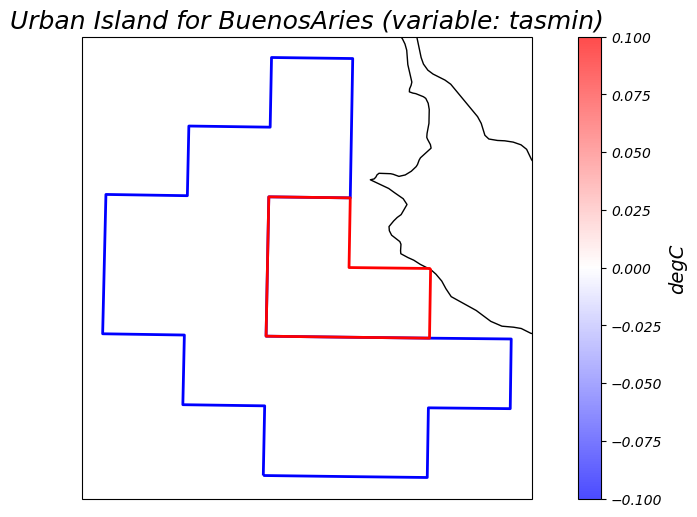

In [58]:
fig = UHI.plot_UI_map(
    city_name = city,
)
fig.savefig(f"{output_dir}/{variable}_{base_filename}_map-anom-wrt-rural.pdf", bbox_inches='tight')

### Compute the annual cycle climatology of anomalies with respect to rural vicinity mean

TypeError: 'list' object cannot be interpreted as an integer

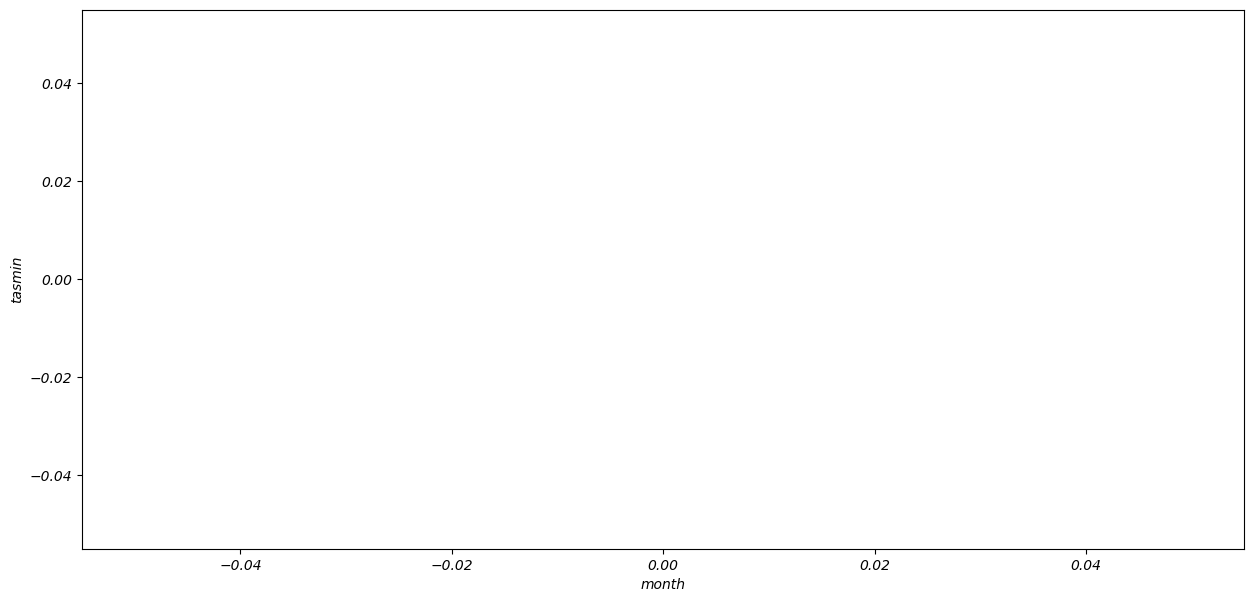

In [60]:
fig = UHI.plot_UI_annual_cycle(
    percentiles = [5],
    gridcell_series = True, 
    city_name = city)

# Paris

## CORDEX-CORE (0.22) REMO

In [69]:
city = 'Paris'
lon_city = 2.35
lat_city = 48.85

domain = 'EUR-22'
model = 'REMO'
scenario = "evaluation"

urban_var = 'sftimf'

urban_th = 10
urban_sur_th = 10
orog_diff = 100
sftlf_th = 70
scale = 2
min_city_size = 0
lon_lim = 1
lat_lim = 1

Create a directory to save the results for this particular city and model

In [70]:
base_output_dir = 'results'
output_dir = f"{base_output_dir}/{city}-{domain}_{model}"
os.makedirs(output_dir, exist_ok = True)

Infer doman resolution in degrees and create filename

In [71]:
domain_resolution = int(domain.split('-')[1])
base_filename = f'{city}-{domain}_ECMWF-ERA5_{scenario}_r1i1p1f1_{model}'

## Define urban areas and vicinity

### Load static variables
Load static variables, such as urban fraction (sfturf), terrain elevation (orography) or land-sea fraction (sftlf).

In [72]:
root_nextcloud = '/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'
root_esgf = "/lustre/gmeteo/DATA/ESGF/REPLICA/DATA/cordex/output/"

In [73]:
file_sfturf = glob.glob(
        f"{root_nextcloud}{model}/{urban_var}/{urban_var}_{domain}*.nc" 
)

file_orog = glob.glob(
    f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/ECMWF-ERAINT/evaluation/*/{RCM_DICT[domain][model].split('_')[1]}/*/fx/orog/*/orog_*.nc" 
)
file_sftlf = glob.glob(
    f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/ECMWF-ERAINT/evaluation/*/{RCM_DICT[domain][model].split('_')[1]}/*/fx/sftlf/*/sftlf_*.nc" 
)

In [74]:
ds_sfturf = xr.open_dataset(file_sfturf[0])
ds_orog = xr.open_dataset(file_orog[0])
ds_sftlf = xr.open_dataset(file_sftlf[0])

ds_sfturf = fix_360_longitudes(ds_sfturf)
ds_orog = fix_360_longitudes(ds_orog)
ds_sftlf = fix_360_longitudes(ds_sftlf)

Add parameters to the function

In [75]:
URBAN = Urban_vicinity(
    urban_th, 
    urban_sur_th, 
    orog_diff, 
    sftlf_th,
    scale,
    min_city_size,
    lon_city,
    lat_city,
    lon_lim,
    lat_lim,
    model,
    domain,
    urban_var)

Crop area around de city

In [76]:
ds_sfturf = URBAN.crop_area_city(ds_sfturf, domain_resolution)
ds_orog = URBAN.crop_area_city(ds_orog, domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds_sftlf, domain_resolution)

Define masks using the parameters above

In [77]:
sfturf_mask, sfturf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sfturf, 
    ds_orog, 
    ds_sftlf
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [78]:
urmask = URBAN.select_urban_vicinity(
    sfturf_mask, 
    orog_mask,
    sftlf_mask,
    sfturf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

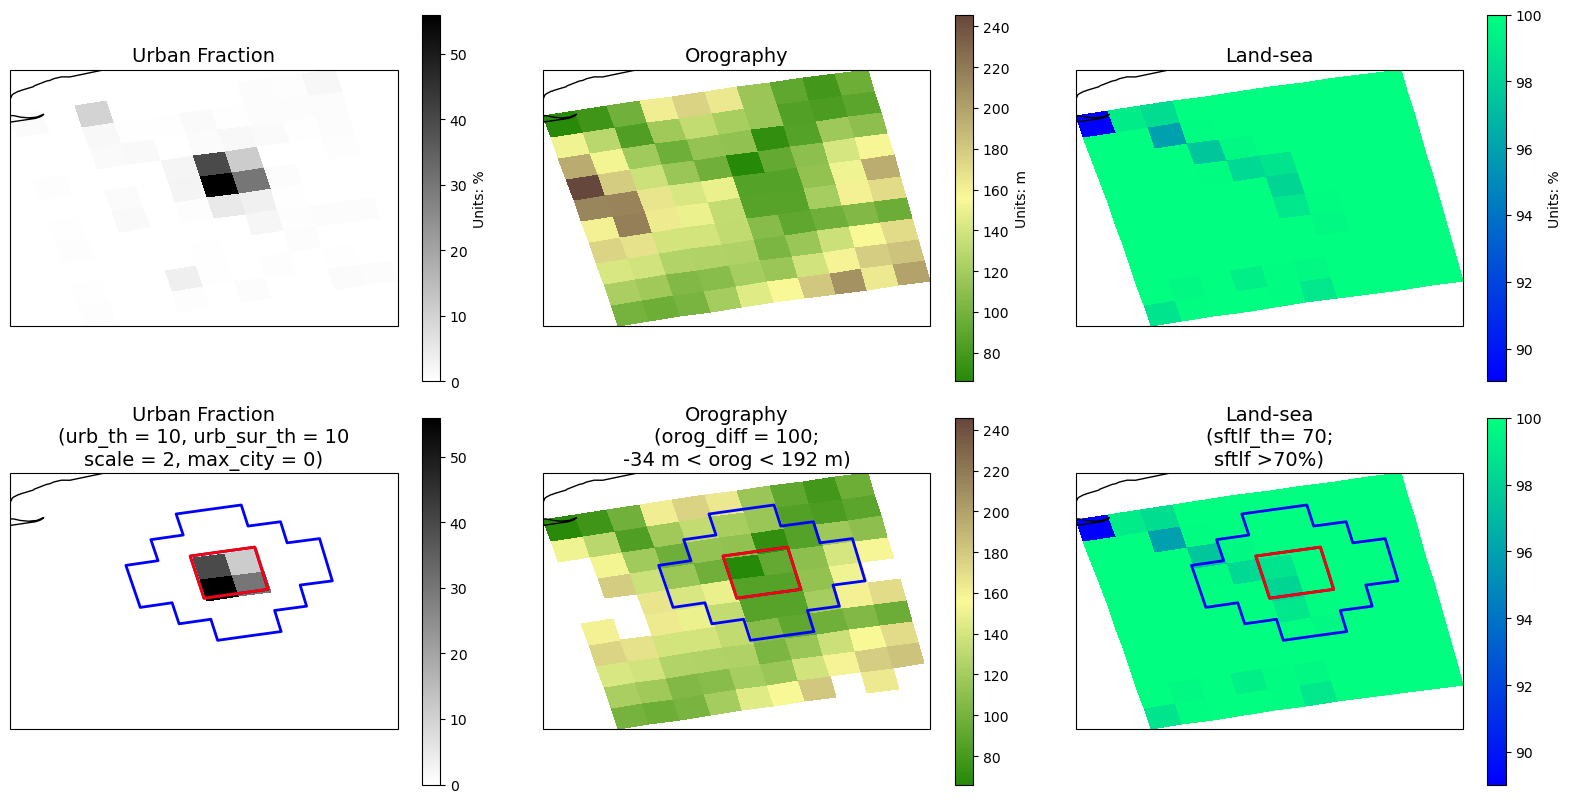

In [79]:
fig = URBAN.plot_static_variables(ds_sfturf, ds_orog, ds_sftlf,
                                 sfturf_mask, orog_mask, sftlf_mask,
                                 urban_areas = urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.png", bbox_inches='tight')

Save these masks and urban fraction to NetCDF

In [22]:
urmask.to_netcdf(f"{output_dir}/urmask_{base_filename}_fx.nc")

## Calculate urban heat island effect

### Load climate variable

In [81]:
variable = 'tasmin'

In [85]:
files_pattern = f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/*/{scenario}/*/{RCM_DICT[domain][model].split('_')[1]}/*/day/{variable}/*/{variable}_*.nc"
files = glob.glob(files_pattern)
ds_RCM = xr.open_mfdataset(sorted(files), combine='nested', concat_dim='time').compute()
ds_RCM = kelvin2degC(ds_RCM, variable)
ds_RCM = fix_360_longitudes(ds_RCM)
ds_RCM = URBAN.crop_area_city(ds_RCM, domain_resolution).compute()

### Compute the climatology of anomalies with respect to rural vicinity mean

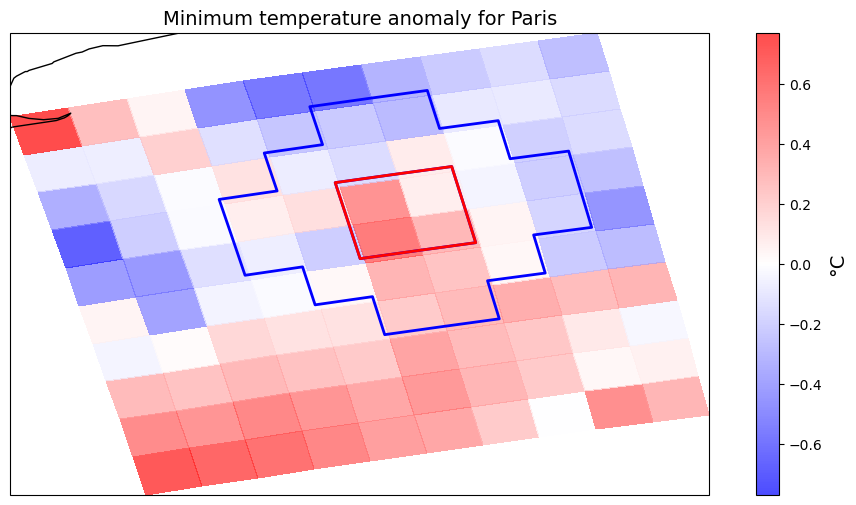

In [86]:
fig = plot_climatology(ds_RCM, urmask, variable, URBAN,
                       city = city,
                       alpha_urb_borders = 1,
                       linewidth_urb_borders = 0.6
                      )
fig.savefig(f"{output_dir}/{variable}_{base_filename}_map-anom-wrt-rural.pdf", bbox_inches='tight')

### Compute the annual cycle climatology of anomalies with respect to rural vicinity mean

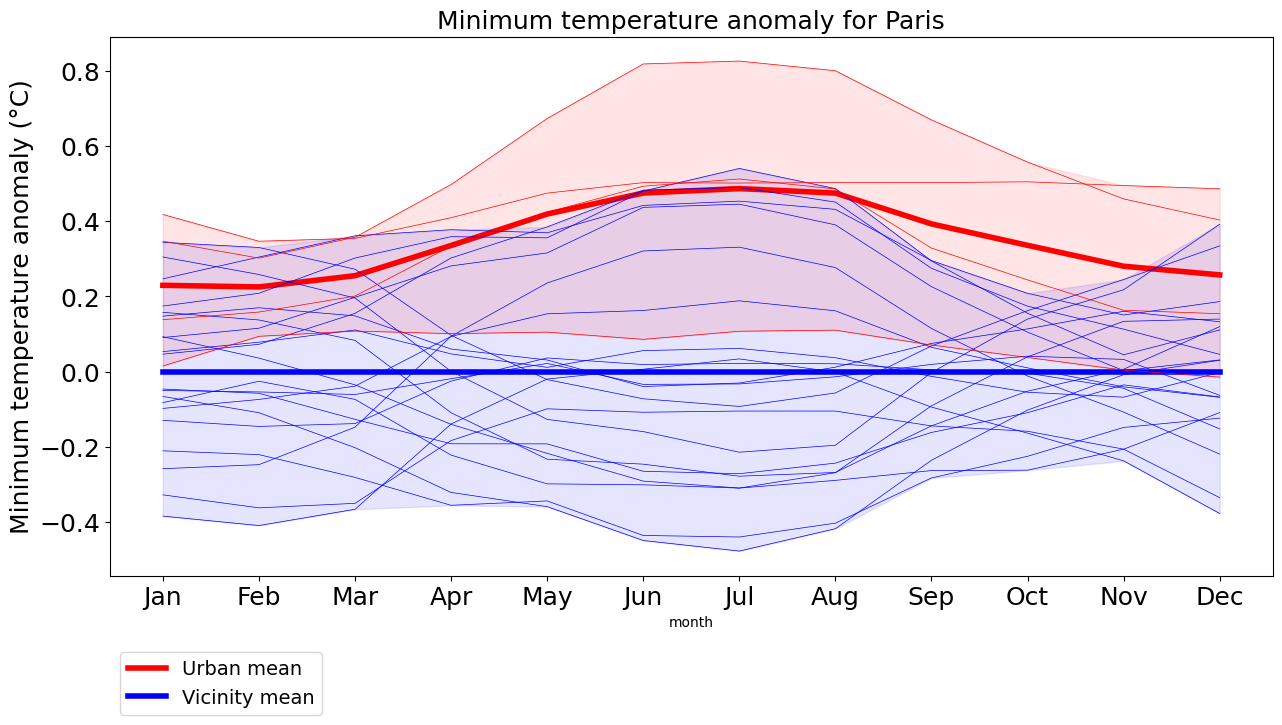

In [87]:
fig = plot_time_series(ds_RCM, variable, urmask, 
    data_squares = True, city = city)

## EUR-CORDEX (0.11) REMO

In [113]:
city = 'Paris'
lon_city = 2.35
lat_city = 48.85

domain = 'EUR-11'
model = 'REMO'
scenario = "evaluation"

urban_var = 'sftimf'

urban_th = 40
urban_sur_th = 10
orog_diff = 100
sftlf_th = 70
scale = 2
min_city_size = 2
lon_lim = 1
lat_lim = 1

Create a directory to save the results for this particular city and model

In [114]:
base_output_dir = 'results'
output_dir = f"{base_output_dir}/{city}-{domain}_{model}"
os.makedirs(output_dir, exist_ok = True)

Infer doman resolution in degrees and create filename

In [115]:
domain_resolution = int(domain.split('-')[1])
base_filename = f'{city}-{domain}_ECMWF-ERA5_{scenario}_r1i1p1f1_{model}'

## Define urban areas and vicinity

### Load static variables
Load static variables, such as urban fraction (sfturf), terrain elevation (orography) or land-sea fraction (sftlf).

In [116]:
root_nextcloud = '/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'
root_esgf = "/lustre/gmeteo/DATA/ESGF/REPLICA/DATA/cordex/output/"

In [117]:
file_sfturf = glob.glob(
        f"{root_nextcloud}{model}/{urban_var}/{urban_var}_{domain}*.nc" 
)

file_orog = glob.glob(
    f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/ECMWF-ERAINT/evaluation/*/{RCM_DICT[domain][model].split('_')[1]}/*/fx/orog/*/orog_*.nc" 
)
file_sftlf = glob.glob(
    f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/ECMWF-ERAINT/evaluation/*/{RCM_DICT[domain][model].split('_')[1]}/*/fx/sftlf/*/sftlf_*.nc" 
)

In [118]:
ds_sfturf = xr.open_dataset(file_sfturf[0])
ds_orog = xr.open_dataset(file_orog[0])
ds_sftlf = xr.open_dataset(file_sftlf[0])

ds_sfturf = fix_360_longitudes(ds_sfturf)
ds_orog = fix_360_longitudes(ds_orog)
ds_sftlf = fix_360_longitudes(ds_sftlf)

Add parameters to the function

In [119]:
URBAN = Urban_vicinity(
    urban_th, 
    urban_sur_th, 
    orog_diff, 
    sftlf_th,
    scale,
    min_city_size,
    lon_city,
    lat_city,
    lon_lim,
    lat_lim,
    model,
    domain,
    urban_var)

Crop area around de city

In [120]:
ds_sfturf = URBAN.crop_area_city(ds_sfturf, domain_resolution)
ds_orog = URBAN.crop_area_city(ds_orog, domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds_sftlf, domain_resolution)

Define masks using the parameters above

In [121]:
sfturf_mask, sfturf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sfturf, 
    ds_orog, 
    ds_sftlf
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [122]:
urmask = URBAN.select_urban_vicinity(
    sfturf_mask, 
    orog_mask,
    sftlf_mask,
    sfturf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

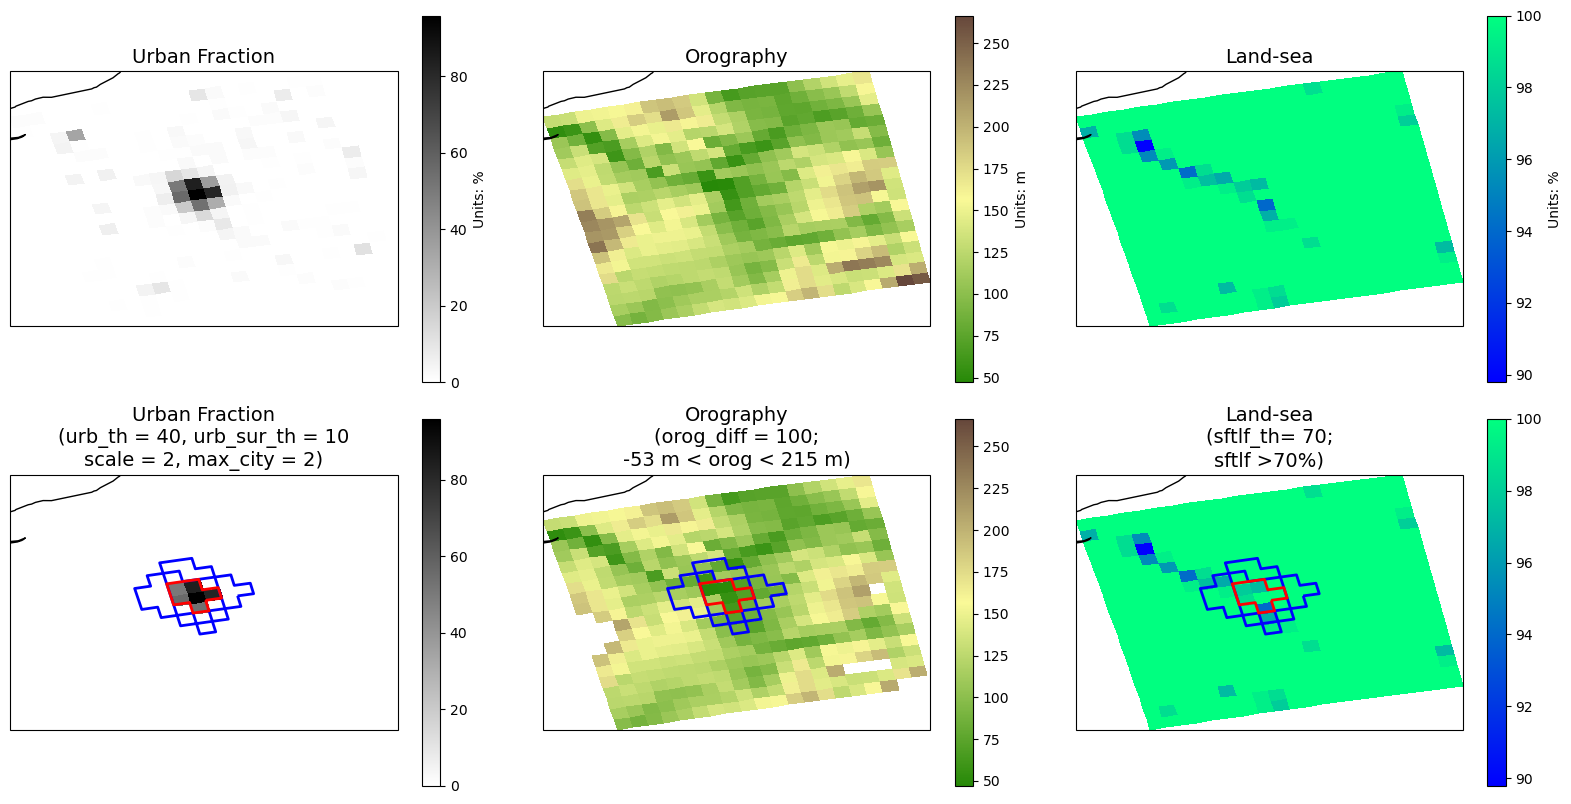

In [123]:
fig = URBAN.plot_static_variables(ds_sfturf, ds_orog, ds_sftlf,
                                 sfturf_mask, orog_mask, sftlf_mask,
                                 urban_areas = urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.png", bbox_inches='tight')

Save these masks and urban fraction to NetCDF

In [124]:
urmask.to_netcdf(f"{output_dir}/urmask_{base_filename}_fx.nc")

## Calculate urban heat island effect

### Load climate variable

In [125]:
variable = 'tasmin'

In [126]:
files_pattern = f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/*/{scenario}/*/{RCM_DICT[domain][model].split('_')[1]}/*/day/{variable}/*/{variable}_*.nc"
files = glob.glob(files_pattern)
ds_RCM = xr.open_mfdataset(sorted(files), combine='nested', concat_dim='time').compute()
ds_RCM = kelvin2degC(ds_RCM, variable)
ds_RCM = fix_360_longitudes(ds_RCM)
ds_RCM = URBAN.crop_area_city(ds_RCM, domain_resolution).compute()

### Compute the climatology of anomalies with respect to rural vicinity mean

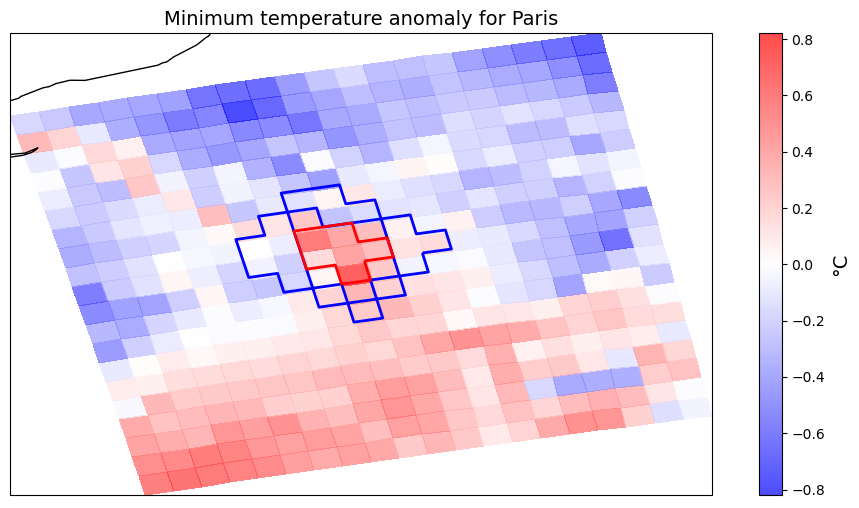

In [127]:
fig = plot_climatology(ds_RCM, urmask, variable, URBAN,
                       city = city,
                       alpha_urb_borders = 1,
                       linewidth_urb_borders = 0.6
                      )
fig.savefig(f"{output_dir}/{variable}_{base_filename}_map-anom-wrt-rural.pdf", bbox_inches='tight')

### Compute the annual cycle climatology of anomalies with respect to rural vicinity mean

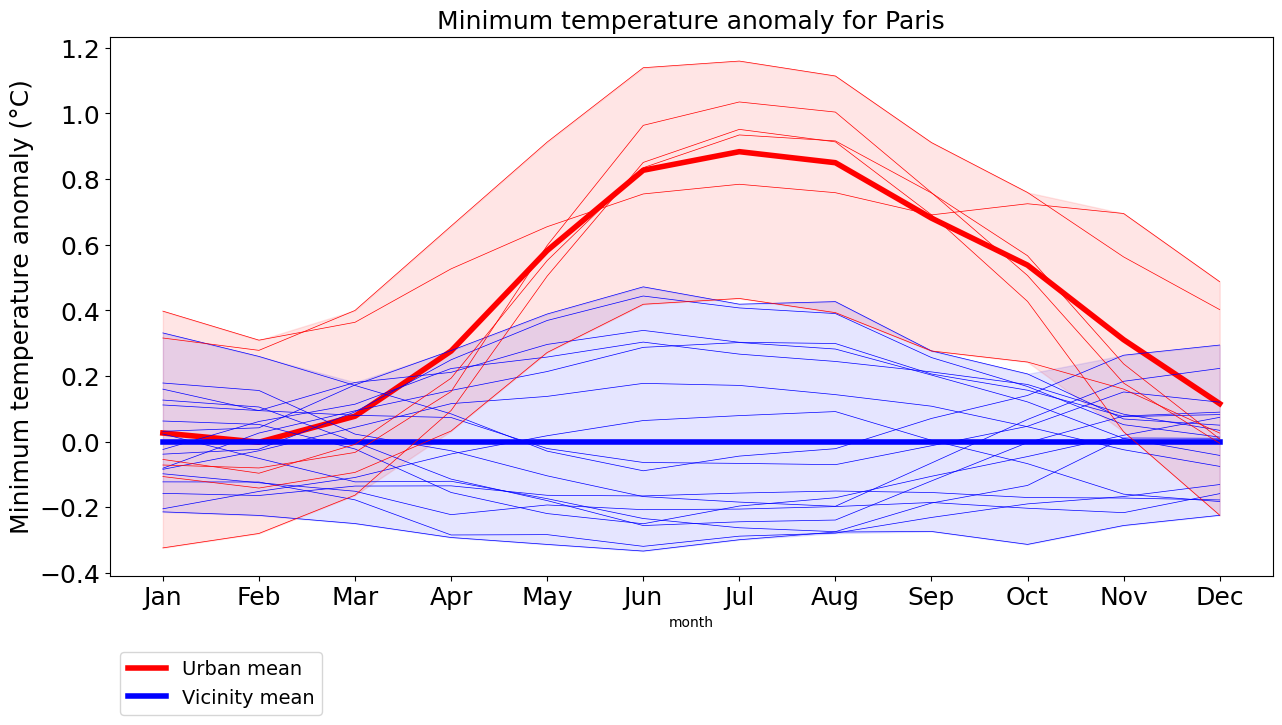

In [128]:
fig = plot_time_series(ds_RCM, variable, urmask, 
    data_squares = True, city = city)

## ALPX-3f (0.03) WRF451I

In [82]:
city = 'Paris'
lon_city = 2.35
lat_city = 48.85

domain = 'ALPX-3'
model = 'WRF451I'
scenario = "evaluation"

urban_var = 'sfturf'

urban_th = 99.9
urban_sur_th = 99.9
orog_diff = 100
sftlf_th = 70
scale = 1
min_city_size = 20
lon_lim = 1
lat_lim = 1

Create a directory to save the results for this particular city and model

In [83]:
base_output_dir = 'results'
output_dir = f"{base_output_dir}/{city}-{domain}_{model}"
os.makedirs(output_dir, exist_ok = True)

Infer doman resolution in degrees and create filename

In [84]:
domain_resolution = int(domain.split('-')[1])
base_filename = f'{city}-{domain}_ECMWF-ERA5_{scenario}_r1i1p1f1_{model}'

## Define urban areas and vicinity

### Load static variables
Load static variables, such as urban fraction (sfturf), terrain elevation (orography) or land-sea fraction (sftlf).

In [85]:
root = "/gpfs/projects/meteo/WORK/ASNA/projects/impetus/04_I4C_historical/data/postprocessed/I4C/CMIP6/DD/ALPX-3f/BCCR-UCAN/NorESM2-MM/historical/r1i1p1f1/WRF451I/v1-r1/"

In [86]:
ds_sfturf = xr.open_dataset(f"{root}fx/sfturf/v20240710/sfturf_ALPX-3f_NorESM2-MM_historical_r1i1p1f1_BCCR-UCAN_WRF451I_v1-r1_fx.nc")
ds_orog = xr.open_dataset(f"{root}fx/orog/v20240710/orog_ALPX-3f_NorESM2-MM_historical_r1i1p1f1_BCCR-UCAN_WRF451I_v1-r1_fx.nc")
ds_sftlf = xr.open_dataset(f"{root}fx/sftlf/v20240710/sftlf_ALPX-3f_NorESM2-MM_historical_r1i1p1f1_BCCR-UCAN_WRF451I_v1-r1_fx.nc")

ds_sfturf = fix_360_longitudes(ds_sfturf)
ds_orog = fix_360_longitudes(ds_orog)
ds_sftlf = fix_360_longitudes(ds_sftlf)

Add parameters to the function

In [87]:
URBAN = Urban_vicinity(
    urban_th, 
    urban_sur_th, 
    orog_diff, 
    sftlf_th,
    scale,
    min_city_size,
    lon_city,
    lat_city,
    lon_lim,
    lat_lim,
    model,
    domain,
    urban_var)

Crop area around de city

In [88]:
ds_sfturf = URBAN.crop_area_city(ds_sfturf, domain_resolution)
ds_orog = URBAN.crop_area_city(ds_orog, domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds_sftlf, domain_resolution)

Define masks using the parameters above

In [89]:
sfturf_mask, sfturf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sfturf, 
    ds_orog, 
    ds_sftlf
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [90]:
urmask = URBAN.select_urban_vicinity(
    sfturf_mask, 
    orog_mask,
    sftlf_mask,
    sfturf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

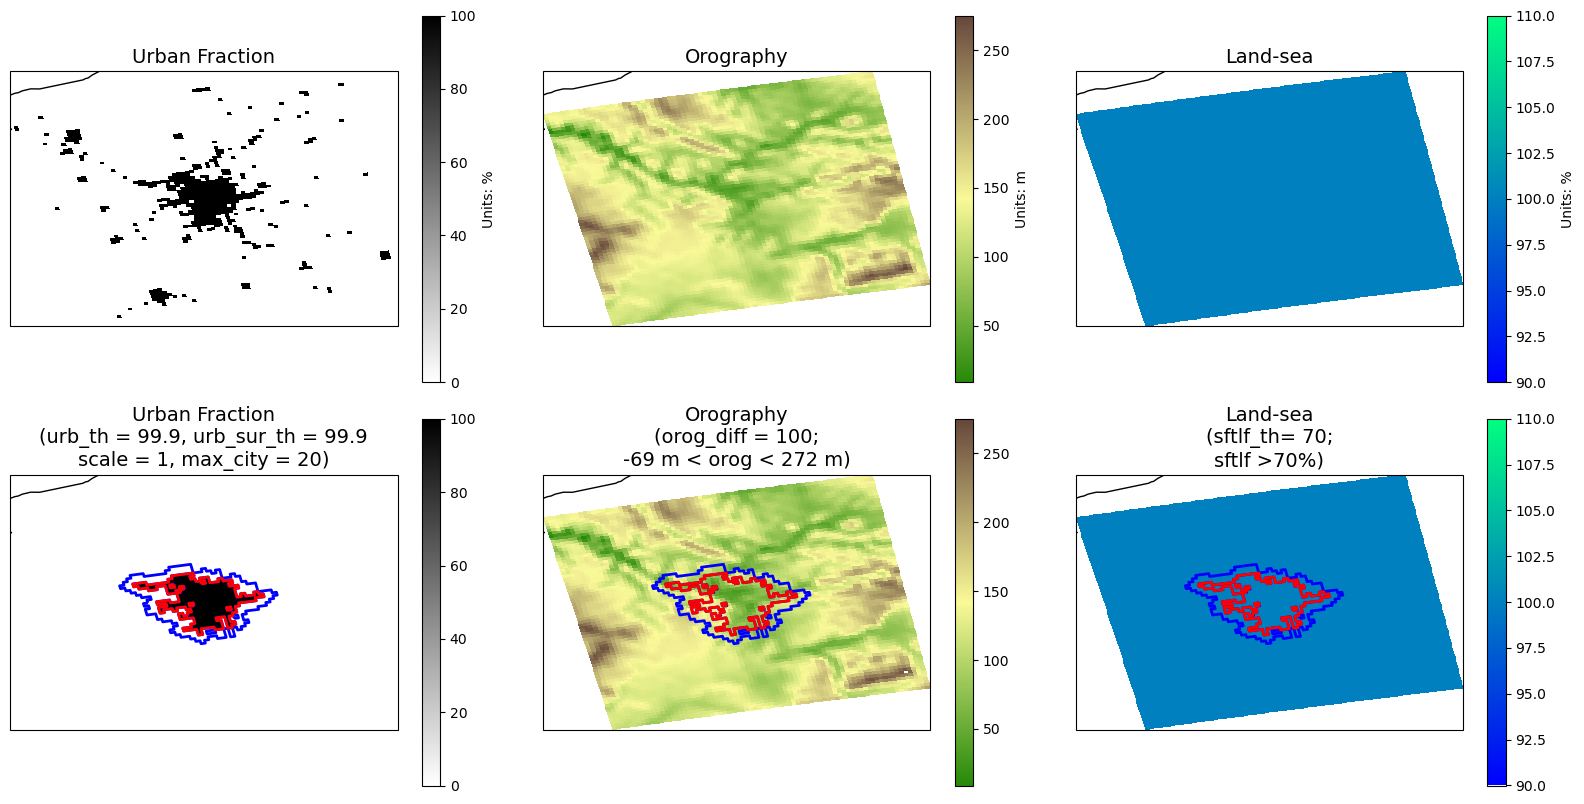

In [91]:
fig = URBAN.plot_static_variables(ds_sfturf, ds_orog, ds_sftlf,
                                 sfturf_mask, orog_mask, sftlf_mask,
                                 urban_areas = urmask)
#fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')
#fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.png", bbox_inches='tight')

Save these masks and urban fraction to NetCDF

In [92]:
urmask.to_netcdf(f"{output_dir}/urmask_{base_filename}_fx.nc")

## Calculate urban heat island effect

### Load climate variable

In [93]:
variable = 'tas'

In [94]:
files = np.sort(glob.glob(f"{root}1hr/tas/v20240710/*"))
ds_RCM = xr.open_mfdataset(sorted(files), combine='nested', concat_dim='time', decode_times=False)
ds_RCM = URBAN.crop_area_city(ds_RCM, domain_resolution).compute()

In [95]:
#ds_RCM = fix_non_standard_calendar(ds_RCM)

In [96]:
# Inspect time attributes
time_units = ds_RCM.time.attrs["units"]  # e.g., "days since 2000-01-01"
calendar = ds_RCM.time.attrs.get("calendar", "standard")  # Default to "standard" if not specified

# Convert raw time values to cftime objects
raw_time = ds_RCM.time.values  # Raw numerical time values

# Parse the units to extract the reference date
ref_date = pd.Timestamp(time_units.split("since")[1].strip())

# Create datetime objects using cftime
time_converted = [
        cftime.DatetimeNoLeap(ref_date.year, ref_date.month, ref_date.day) + pd.Timedelta(days=float(t))
        for t in raw_time
    ]

# Assign the converted time back to the dataset
ds_RCM = ds_RCM.assign_coords(time=("time", time_converted))

In [97]:
ds_RCM = ds_RCM.resample(time = '1D').min()
ds_RCM = kelvin2degC(ds_RCM, variable)
ds_RCM = fix_360_longitudes(ds_RCM)

### Compute the climatology of anomalies with respect to rural vicinity mean

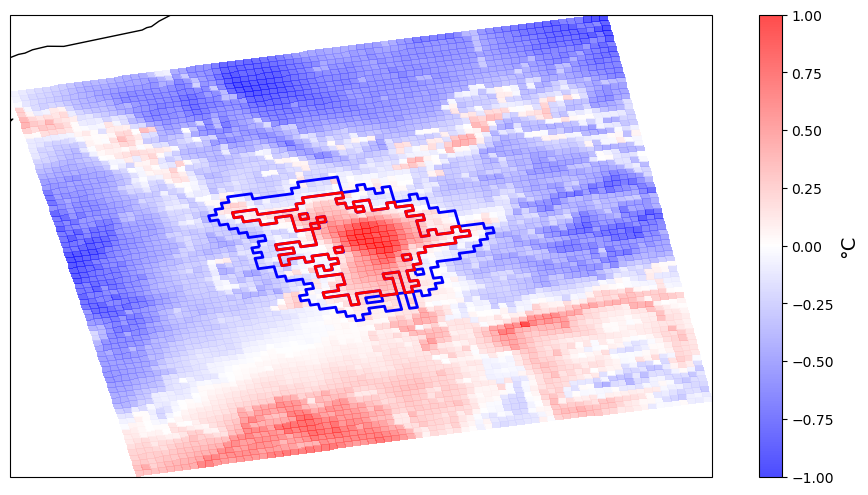

In [100]:
fig = plot_climatology(ds_RCM, urmask, variable, URBAN,
                       city = city,
                       alpha_urb_borders = 1,
                       linewidth_urb_borders = 0.6
                      )
fig.savefig(f"{output_dir}/{variable}_{base_filename}_map-anom-wrt-rural.pdf", bbox_inches='tight')

### Compute the annual cycle climatology of anomalies with respect to rural vicinity mean

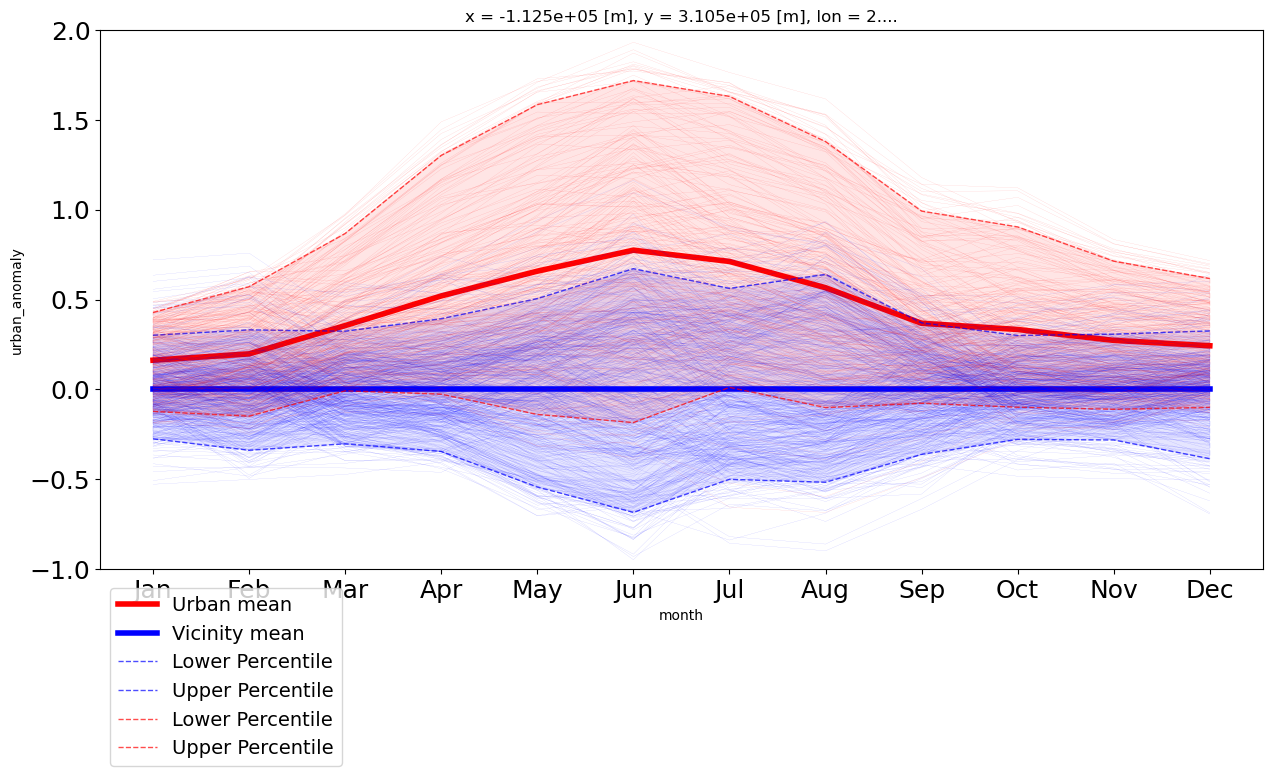

In [102]:
fig = plot_time_series(ds_RCM, variable, urmask, 
    data_squares = True, city = city)